# EDMD-DL Tests on Duffing Oscillator

## Train the Model

Import necessary modules

In [1]:
import sys
sys.path.append('..')
import importlib
import KoopmanDL as kdl
import torch
import matplotlib.pyplot as plt
# importlib.reload(kdl)

CUDA is available. GPU is being used.
Project root dir is set to: /home/yxqian/code/deep_learning/MyKoopmanDL


Generate the data set

In [2]:
alpha = 2.0
dt = 1e-3
n_init = 1300
traj_len = 10
traj_t_step = 0.25
x_min = -5
x_max = 5
seed = 0
n_train = 10000
n_valid = 3000

duffing = kdl.VanDerPolOscillator(alpha)
flowmap = kdl.ForwardEuler(dt)
data_x_all = flowmap.generate_traj_data(duffing, n_init, traj_len, traj_t_step, x_min, x_max, seed)
data_y_all = flowmap.generate_next_data(duffing, data_x_all, traj_t_step)
dataset = kdl.DataSet(data_x_all, data_y_all)
data_train, data_valid = dataset.split(n_train)

Visualize train data

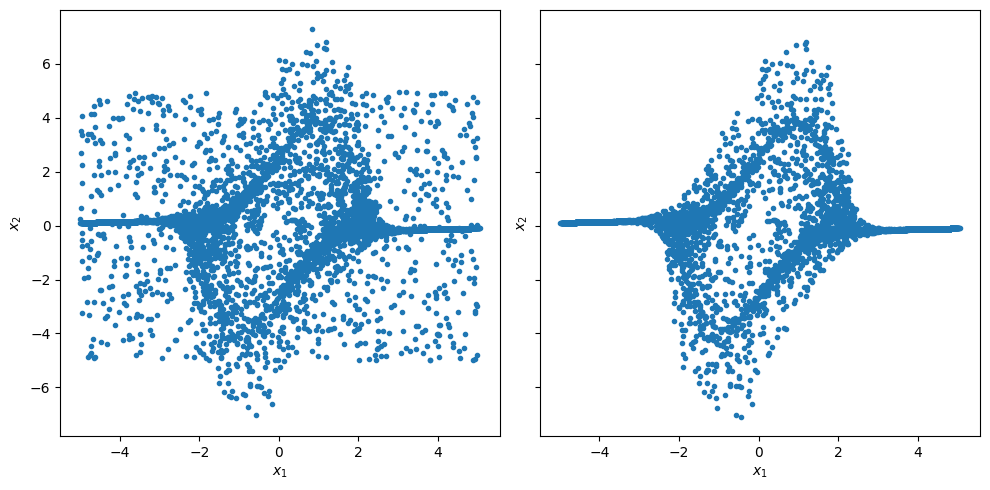

In [3]:
fig, (ax1,ax2) = plt.subplots(1,2,sharey=True, figsize=(10,5))
data_x_train = data_train.data()
ax1.plot(data_x_train[:,0], data_x_train[:,1], '.')
ax1.set_xlabel(r'$x_{1}$')
ax1.set_ylabel(r'$x_{2}$')
data_y_train = data_train.labels()
ax2.plot(data_y_train[:,0], data_y_train[:,1], '.')
ax2.set_xlabel(r'$x_{1}$')
ax2.set_ylabel(r'$x_{2}$')
plt.tight_layout()

Visualize validation data

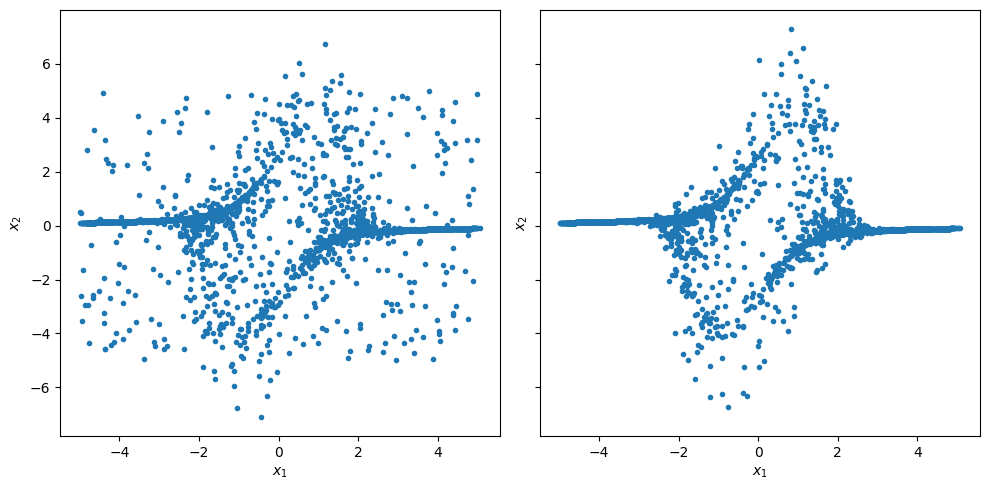

In [4]:
fig, (ax1,ax2) = plt.subplots(1,2,sharey=True, figsize=(10,5))
data_x_valid = data_valid.data()
ax1.plot(data_x_valid[:,0], data_x_valid[:,1], '.')
ax1.set_xlabel(r'$x_{1}$')
ax1.set_ylabel(r'$x_{2}$')
data_y_valid = data_valid.labels()
ax2.plot(data_y_valid[:,0], data_y_valid[:,1], '.')
ax2.set_xlabel(r'$x_{1}$')
ax2.set_ylabel(r'$x_{2}$')
plt.tight_layout()

Build up the solver

In [5]:
D = 2
M = 25
non_trainables = D + 1
hidden_layer_sizes = [100, 100, 100]
lr = 1e-4
reg = 0.1
reg_final = 0.01
n_epochs = 3000
batch_size = 10000


net = kdl.TanhResNetWithNonTrainable(D, M, hidden_layer_sizes, non_trainables)
opt = torch.optim.Adam(net.parameters(), lr)
dic = kdl.TrainableDictionary(M, net, opt)
solver = kdl.EDMDDLSolver(dic, reg)

In [6]:
# train
solver.solve(data_x_train, data_y_train, n_epochs, batch_size)

Training: 100%|██████████| 3000/3000 [10:17<00:00,  4.86it/s, loss=2.28e-05]


In [7]:
# compute eigenvalues and eigenvectors
K = solver.compute_K(data_x_train, data_y_train, reg_final)
solver.compute_eig(K)

In [8]:
# save to/load from file
model_path = kdl.root_dir + '/model/vdp.pth'
solver.save(model_path)
# solver.load(model_path)

## Plot the Eigenvalues

In [9]:
rbf_M = 100
rbf_regularizer = 1e-4
traj_len = 50

rbf_basis_func = kdl.RBFDictionary(rbf_M, rbf_regularizer)
rbf_basis_func.build(data_x_train)
rbf_solver = kdl.EDMDSolver(rbf_basis_func)
K = rbf_solver.compute_K(data_x_train, data_y_train)
rbf_solver.compute_eig(K)

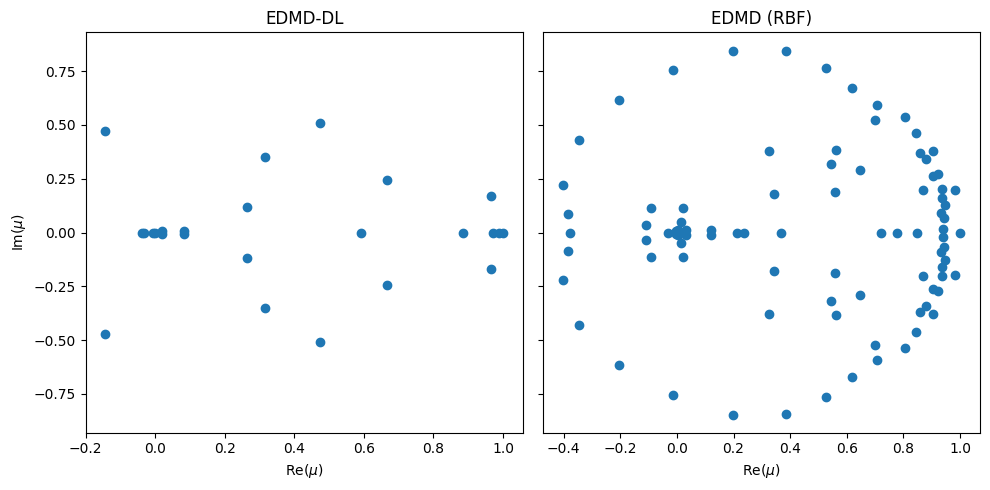

In [10]:
import numpy as np
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharex=False, sharey=True)
ax1.scatter(solver.eigenvalues.real,solver.eigenvalues.imag)
ax1.set_xlabel(r'Re$(\mu)$')
ax1.set_ylabel(r'Im$(\mu)$')
ax1.set_title('EDMD-DL')

ax2.scatter(rbf_solver.eigenvalues.real, rbf_solver.eigenvalues.imag)
ax2.set_xlabel(r'Re$(\mu)$')
ax2.set_title('EDMD (RBF)')

fig.tight_layout()

## Reconstruction

In [23]:
n_init = 1
traj_len = 50
# seed = 111  # I don't know why, but the method seems not work well with seed 111.
seed = 123
traj_t_step = 0.25
x_min = -2
x_max = 2

data_x_test = flowmap.generate_traj_data(duffing, n_init, traj_len, traj_t_step, x_min, x_max, seed)
data_y_test = flowmap.generate_next_data(duffing, data_x_test, traj_t_step)
x_traj = data_x_test

x0_test = data_x_test[0].unsqueeze(0)
x_est_traj_DL = solver.predict(x0_test, traj_len)
x_est_traj_rbf = rbf_solver.predict(x0_test, traj_len)
DL_error = torch.sqrt(torch.mean(torch.square(x_est_traj_DL - x_traj))) 
rbf_error = torch.sqrt(torch.mean(torch.square(x_est_traj_rbf - x_traj))) 
print ("DL error: ", DL_error.item(),
      "  RBF error: ", rbf_error.item())

DL error:  0.083644337952137   RBF error:  0.1130618155002594


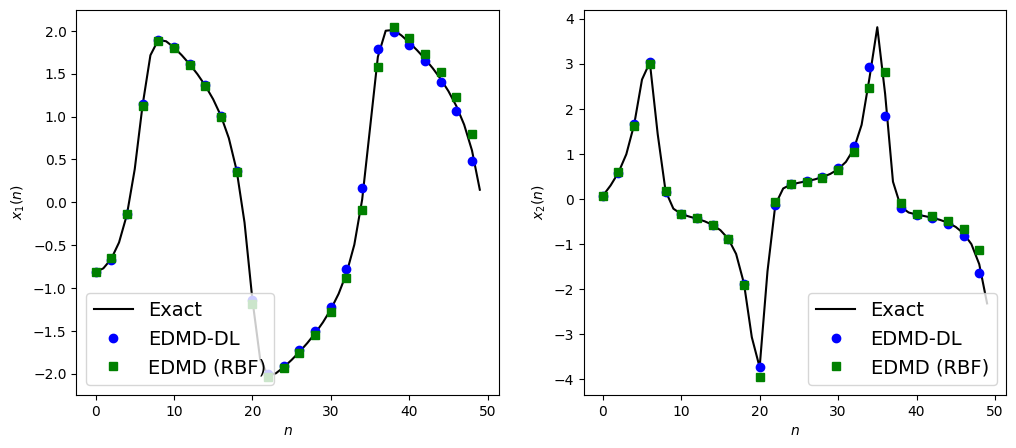

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(12,5))  

x_est_traj_DL = x_est_traj_DL.detach()
# Plot
t_grid = np.arange(0,traj_len)
ax1.plot(t_grid, x_traj[:,0], 'k-', label='Exact', markevery=2)
ax1.plot(t_grid, x_est_traj_DL[:,0], 'bo', label='EDMD-DL', markevery=2)
ax1.plot(t_grid, x_est_traj_rbf[:,0], 'gs', label='EDMD (RBF)', markevery=2)
    
ax2.plot(t_grid, x_traj[:,1], 'k-', label='Exact', markevery=2)
ax2.plot(t_grid, x_est_traj_DL[:,1], 'bo', label='EDMD-DL', markevery=2)
ax2.plot(t_grid, x_est_traj_rbf[:,1], 'gs', label='EDMD (RBF)', markevery=2)

ax1.set_xlabel(r"$n$")
ax1.set_ylabel(r"$x_{1}(n)$")
ax1.legend(loc='best',prop={'size':14})

ax2.set_xlabel(r"$n$")
ax2.set_ylabel(r"$x_{2}(n)$")
ax2.legend(loc='best',prop={'size':14})


## Check eigenfunction quality

In [19]:
# Generate dynamical data
xmin, xmax = -5, 5
dim = 2
ds = 0.2
num_print = 8
x_grid = torch.tensor(np.mgrid[xmin:xmax+ds:ds, xmin:xmax+ds:ds].reshape(dim,-1).T).to(torch.float)

# DL
phi_DL = solver.eigenfunctions(x_grid).t()
phif_DL = solver.eigenfunctions(flowmap.generate_next_data(duffing, x_grid, traj_t_step)).t()
mu_DL = solver.eigenvalues
error_DL = torch.mean(((phi_DL*mu_DL)-phif_DL)**2 , axis=0)
print("DL Eigenfunction errors:\n", torch.abs(error_DL)[0:8])


# rbf
phi_rbf = rbf_solver.eigenfunctions(x_grid).t()
phif_rbf = rbf_solver.eigenfunctions(flowmap.generate_next_data(duffing, x_grid, traj_t_step)).t()
mu_rbf = rbf_solver.eigenvalues
error_rbf = torch.mean( ((phi_rbf*mu_rbf)-phif_rbf)**2 , axis=0)
print("rbf Eigenfunction errors:\n", torch.abs(error_rbf)[0:8])

DL Eigenfunction errors:
 tensor([1.1148e-07, 9.3219e-05, 1.2850e-04, 5.0328e-05, 5.0328e-05, 1.1293e-04,
        4.8293e-05, 4.8293e-05], grad_fn=<SliceBackward0>)
rbf Eigenfunction errors:
 tensor([1.3738e-11, 4.7289e-06, 4.7289e-06, 8.8737e-06, 8.8737e-06, 6.3386e-06,
        6.3386e-06, 9.3092e-06], dtype=torch.float64)


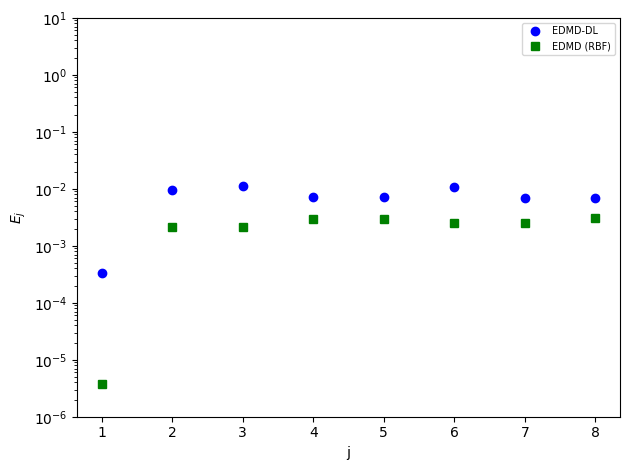

In [20]:
ax = plt.axes()
plt.semilogy(np.sqrt(np.abs(error_DL.detach().numpy())[0:8]), "bo", label="EDMD-DL")
plt.semilogy(np.sqrt(np.abs(error_rbf.detach().numpy()[0:8])), "gs", label="EDMD (RBF)")
plt.legend(loc="best", fontsize='x-small')
ax.set_xticks(np.arange(8))
ax.set_xticklabels(np.arange(1, 9))
ax.set_xlabel("j")
ax.set_ylabel(r"$E_j$")
ax.set_ylim([1e-6, 1e1])
plt.tight_layout()